In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

## New Imports

In [2]:
#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns

## Dates & Other Constants

In [3]:
# Define path to files
PATH = "\\Users\\Asus\\Documents\\Python for Finance\\"

# Start date defaults
S_YEAR = 2022
S_MONTH = 1
S_DAY = 1
S_DATE_STR = "2020-01-01"
S_DATE_DATETIME = dt.datetime(S_YEAR, S_MONTH, S_DAY)

# End date defaults
E_YEAR = 2023
E_MONTH = 6
E_DAY = 30
E_DATE_STR = "2023-06-30"
E_DATE_DATETIME = dt.datetime(E_YEAR, E_MONTH, E_DAY)

## Function that Returns a Dataframe from a CSV

In [4]:
def get_df_from_csv(ticker):
    try:
        df = pd.read_csv(PATH + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Regression Analysis

Used to examine the relationship between 2 or more variables. We use it to see what factors matter & which do not. The dependent variable is what you want to better understand, while the independent variable effects the dependent.

When analyzing stocks the dependent variable is the price, while the independent may be the season, economic events, earnings, etc. 

<Axes: xlabel='eval', ylabel='beauty'>

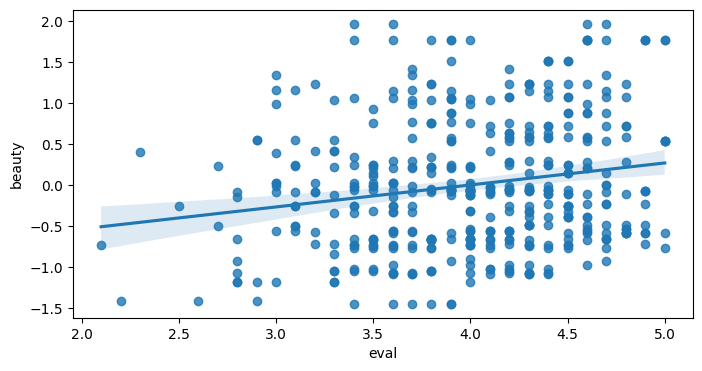

In [5]:
# This is a dataset that evaluates beauty & teacher evaluations
beauty = sm.datasets.get_rdataset("TeachingRatings", "AER")

# We are plotting a scatter plot with a regression line that
# estimates the mean of the results.
plt.figure(figsize=(8,4))
sns.regplot(x="eval", y="beauty", data=beauty.data)

# This data is rather inconclusive

## Tips Regression Line

<Axes: xlabel='total_bill', ylabel='tip'>

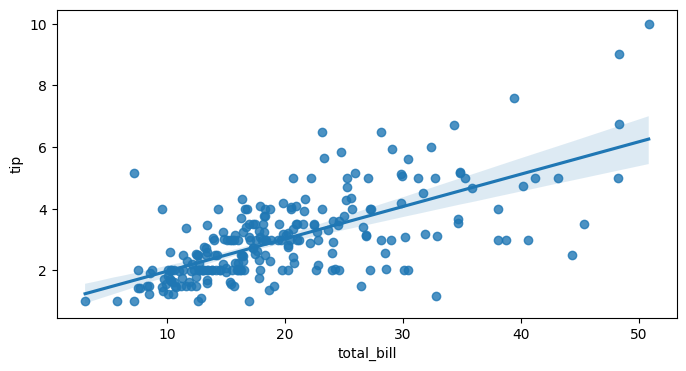

In [6]:
# This time will we analyze whether the total bill effects
# the tip people leave at restaurants
# Load tip dataset
tips = sns.load_dataset("tips")
# Get column data in dataset
tips.columns

y = tips['total_bill']
x1 = tips['tip']

# Define the intercept to the y line
x = sm.add_constant(x1)

# OLS Ordinary Least Squares : Estimates the data so a line can 
# be drawn through data points
results = sm.OLS(y,x).fit()
results.summary()

plt.figure(figsize=(8,4))
sns.regplot(x="total_bill", y="tip", data=tips)

# Here it is clear that are guess that bill amounts effect tips
# seems to be true

## Forecasting

You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

These forecasts are based off of the trends provided by the data you supply. Will it definitely happen? No, but it is more likely to continue on its current trend depending on how dramatic the slope is for the prejection. If nothing dramatic occurs! But, as we know, dramatic things happen such as wars and pandemics.

## ARIMA Model (Auto Regression)

AutoRegressive Integrated Moving Average (ARIMA) is the basis for many other models. It focuses on trying to fit the data as well as possible by examining differences between values instead of the values themselves.

ARIMA works very well when data values have a clear trend and seasonality. We can only make predictions based on the data we have. Any outside effects not in the data can't be used to make predictions. For example we could make predictions on stock prices, but since we don't know when a recession may occur that event can't be modeled.

There is a seasonal (SARIMA) and a non-seasonal ARIMA. There is also SARIMAX which focuses on exogenous, or external factors. It differs from ARIMA in that it has a set of parameters (P, D, and Q) that focus on seasonality.

AR (Autoregressions) refers to a model that regresses based on prior values.

## Regression Time Series Example with sklearn

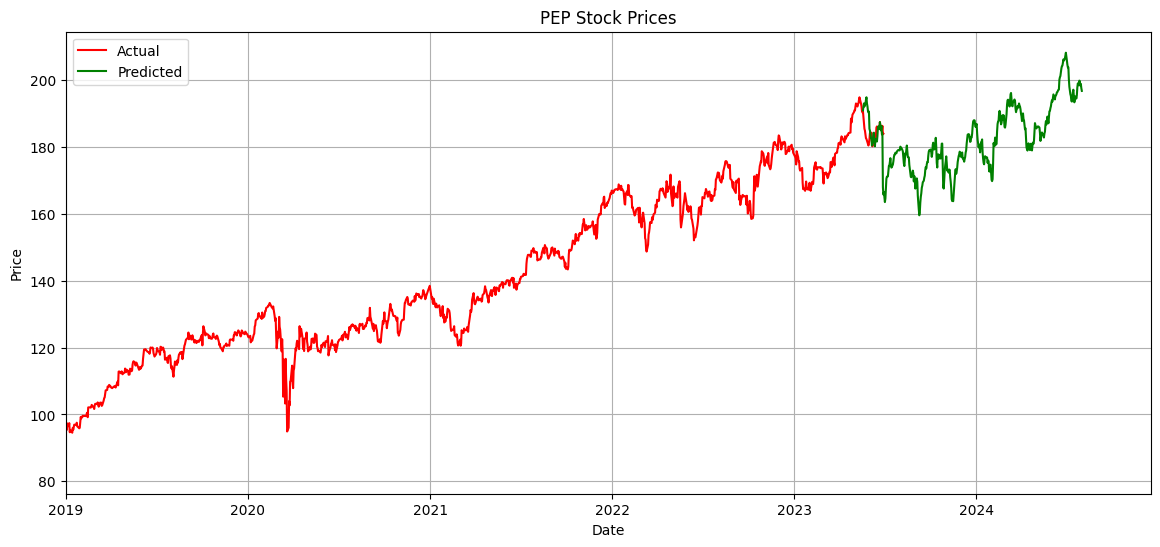

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

#---------------
ticker = "PEP"
datum = "'2019-01-01'"
tan = 150
#---------------

try:
    # Adat betoltese CSV fajlbol
    data = pd.read_csv("C:\\Users\\Asus\\Documents\\Python for Finance\\Python"+ticker+".csv", parse_dates=['Date'], index_col='Date')
except FileNotFoundError:
    print("The file was not found.")
except Exception as e:
    print("An error occurred:", str(e))

# Forward fill-lel feltoltese a hianyzo ertekeknek
data = data.fillna(method='ffill')

# A szukseges oszlopok kivalasztasa
adj_close = data['Adj Close']
daily_returns = data['daily_return']

# Tanulasi adatok elokeszitese
X_train = pd.DataFrame({'Adj Close': adj_close[:-tan], 'Daily Returns': daily_returns[:-tan]})
y_train = adj_close[tan:]

# Elofeldolgozasa az adatoknak, hogy kezeljuk a hianyzo ertekeket
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# A linearis regresszios modellbe helyezes
model = LinearRegression()
model.fit(X_train, y_train)

# Jovo arak meghatarozasa a kovetkezo 600 napi daily return alapjan
future_returns = daily_returns[-400:]
X_future = pd.DataFrame({'Adj Close': adj_close[-400:], 'Daily Returns': future_returns})
X_future = imputer.transform(X_future)
future_adj_close = model.predict(X_future)

# A jovo datumok elkeszitese abrazolashoz
last_date = adj_close.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=440)

# Az utolso 40 nap tenyleges arainak kombinacioja a josolt arakkal
last_40_actual = adj_close[-40:]
combined_adj_close = pd.concat([last_40_actual, pd.Series(future_adj_close)], axis=0)

# Datumok keszitese a kombozott araknak
combined_dates = pd.date_range(start=last_date - pd.DateOffset(days=41), periods=440)

# Abrazolas
plt.figure(figsize=(14, 6))
plt.plot(adj_close.index, adj_close, label='Actual', color="red")
plt.plot(combined_dates, combined_adj_close, label='Predicted', color='green')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(ticker + ' Stock Prices')
plt.xlim(pd.Timestamp(datum), None)  # Milyen datumtol kezdjen
plt.grid(True)
plt.legend()
plt.show()
